# Linear model try
V1.0  
This version is a first build-up of the whole system. 

V2.0  
This version added "central extraction", in which we only extract the central (0.3~0.9) part of videos for testing set.  
In this way, we try to avoid recognizing frames at the beginning and end of the videos that are not the target gesture as much as possible.  
尽可能避免前后识别出来但不是目标手势的帧

### Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt

from model_dataset import HandshapeDataset
from paths import *
from model_model import HandshapePredictor
from model_configs import *
from utils import *
from recorder import *

### Dataset and Dataloader

### Data and Tag Paths

In [2]:
data_train_path = os.path.join(data_dir, data_train_name + "_data.npz")
tag_train_path = os.path.join(data_dir, data_train_name + "_tag.npz")

data_val_path = os.path.join(data_dir, data_validation_name + "_data.npz")
tag_val_path = os.path.join(data_dir, data_validation_name + "_tag.npz")

### Create Dataset

In [3]:
train_ds = HandshapeDataset(data_train_path, tag_train_path)
valid_ds = HandshapeDataset(data_val_path, tag_val_path)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)

### Check size of dataset

In [4]:
print(train_num, valid_num)

15663 4569


## Init Model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = HandshapePredictor(
    input_dim=in_dim, 
    enc_lat_dims=enc_lat_dims, 
    hid_dim=hid_dim, 
    dec_lat_dims=dec_lat_dims, 
    output_dim=out_dim
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
model

HandshapePredictor(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=63, out_features=32, bias=True)
      (relu): ReLU()
    )
    (1): LinPack(
      (lin): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=16, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=5, out_features=16, bias=True)
      (relu): ReLU()
    )
    (1): LinPack(
      (lin): Linear(in_features=16, out_features=32, bias=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=32, out_features=93, bias=True)
  )
)

### Check number of params in model

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

6370


### Prepare for logs

In [8]:
# Just for keeping records of training hists. 
ts = str(get_timestamp())
# ts = "0816184446"
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_{}.hst".format(ts)
save_valhist_name = "val_{}.hst".format(ts)
save_valacc_name = "valacc{}.hst".format(ts)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)
train_losses = LossRecorder(model_save_dir + save_trainhist_name)
valid_accuracies = LossRecorder(model_save_dir + save_valacc_name)
text_hist = HistRecorder(model_save_dir + save_txt_name)

print("NOTE: {} is the series number this time. ".format(ts))

NOTE: 0906192409 is the series number this time. 


### Switch for loading saved records

In [9]:
READ = False
# READ = True

if READ: 
    valid_losses.read()
    train_losses.read()
    valid_accuracies.read()

    # model_name = last_model_namec
    model_name = "PT_0816184446_982_full.pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.to(device)

In [10]:
BASE = 0
EPOCHS = 300

In [13]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, tags) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            
            preds = model(x)

            loss = criterion(preds, tags)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_correct = 0
        valid_total = 0
        valid_num = len(valid_loader)
        for idx, (x, tags) in enumerate(valid_loader):
            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            preds = model(x)    # (B, C)

            loss = criterion(preds, tags)

            valid_loss += loss.item()


            predicted = torch.argmax(nn.Softmax(dim=1)(preds), dim=1)
            valid_total += tags.size(0)
            valid_correct += (predicted == tags).sum().item()

            if idx % 100 == 0:
                # \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f}
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        valid_accuracies.append((100 * valid_correct / valid_total))
        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")
        text_hist.print(f"※※※Valid accuracy {(100 * valid_correct / valid_total): .3f} %※※※")

In [14]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  4.512 in Step 0
Training loss  3.690 in Step 100
Training loss  3.538 in Step 200
Training loss  3.641 in Step 300
Training loss  3.279 in Step 400
※※※Training loss  3.608※※※
Training timepoint saved
Valid loss  3.875 in Step 0
Valid loss  4.819 in Step 100
※※※Valid loss  4.037※※※
※※※Valid accuracy  0.000 %※※※
Epoch 1
Training loss  3.557 in Step 0
Training loss  3.418 in Step 100
Training loss  3.474 in Step 200
Training loss  3.667 in Step 300
Training loss  3.379 in Step 400
※※※Training loss  3.474※※※
Training timepoint saved
Valid loss  3.986 in Step 0
Valid loss  5.068 in Step 100
※※※Valid loss  4.118※※※
※※※Valid accuracy  3.086 %※※※
Epoch 2
Training loss  3.515 in Step 0
Training loss  3.560 in Step 100
Training loss  3.373 in Step 200
Training loss  3.433 in Step 300
Training loss  3.599 in Step 400
※※※Training loss  3.470※※※
Training timepoint saved
Valid loss  4.103 in Step 0
Valid loss  5.020 in Step 100
※※※Valid loss  4.139※※※
※※※Valid accuracy  0.000 

KeyboardInterrupt: 

In [22]:
### Save
valid_losses.save()
valid_accuracies.save()
train_losses.save()
text_hist.save()

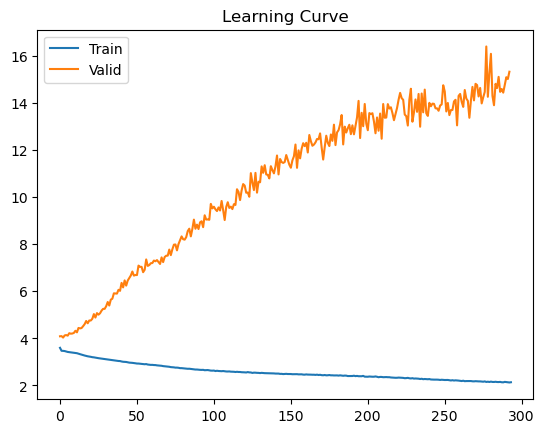

In [13]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve")
plt.legend()

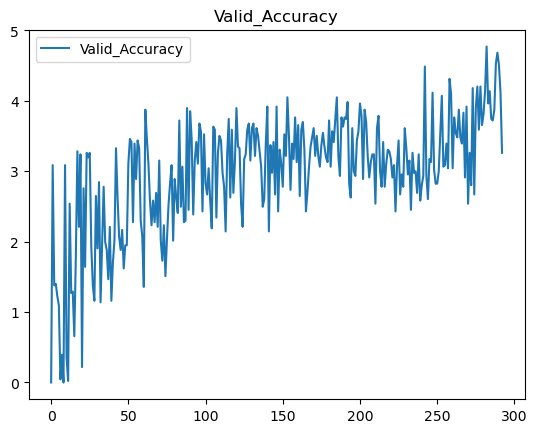

In [14]:
plt.plot(valid_accuracies.get(), label='Valid_Accuracy')
plt.title("Valid_Accuracy")
plt.legend()